In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import Levenshtein
import itertools

import configuration
config = configuration.Config()

In [2]:
regenerate_cached_phono = config.regenerate
phono_data_path = 'csv/phono_data.csv'
if (not os.path.exists(phono_data_path)) or regenerate_cached_phono:
    phono = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order, corpus_name, collection_name, language from token where actual_phonology != "" and model_phonology != ""',
        db_version = "2020.1")
    # cache this phonological information locally
    phono.to_csv(phono_data_path, index=False)
else:
    phono = pd.read_csv(phono_data_path, keep_default_na=False, na_values=[''])

R[write to console]: Using supported database version: '2020.1'.



In [3]:
# remove cases where one is not set
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
phono = phono.loc[~(phono.model_phonology.isin(excludes) |  phono.actual_phonology.isin(excludes))]

In [4]:
phono.shape

(914135, 12)

In [5]:
chi_phono = phono.loc[(phono.speaker_code == 'CHI') & (phono.target_child_age < (365*5))]

In [6]:
chi_phono.shape

(802885, 12)

In [7]:
chi_phono_age = chi_phono[['target_child_age']]
%R -i chi_phono_age

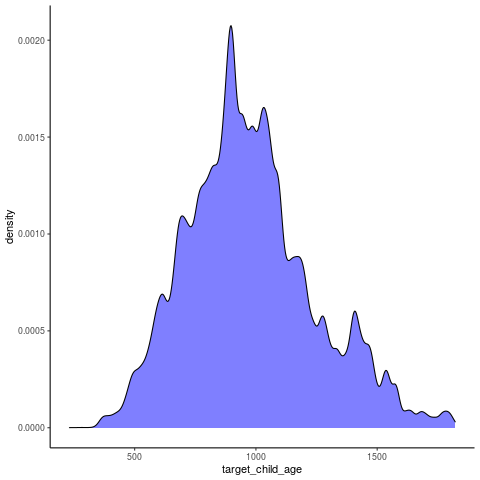

In [8]:
%%R
ggplot(chi_phono_age) + geom_density(aes(x=target_child_age), fill='blue', alpha=.5) + theme_classic()

In [9]:
def lev_wrapper(model_phonology, actual_phonology, normalize=False):
    try: 
        dist = Levenshtein.distance(model_phonology.replace(' ',''),
                        actual_phonology.replace(' ',''))
        if normalize:
            dist = dist / len(model_phonology) # how much of the 
        return(dist)
    except:
        print('Issue calculating Lev distance')
        print(model_phonology)
        print(actual_phonology)
        return(None)

chi_phono['levdist'] = [lev_wrapper(x['model_phonology'], x['actual_phonology'], normalize=True) for x in  chi_phono.to_dict('records')]

/home/nwong/chompsky/childes/child_listening_continuation/child-listening-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
chi_phono.columns

Index(['gloss', 'target_child_name', 'target_child_age', 'speaker_code',
       'actual_phonology', 'model_phonology', 'transcript_id', 'utterance_id',
       'token_order', 'corpus_name', 'collection_name', 'language', 'levdist'],
      dtype='object')

In [11]:
chi_mean_levdist = chi_phono.groupby(['transcript_id','corpus_name','collection_name','language',
                  'target_child_name','target_child_age']).levdist.agg(np.mean).reset_index()
chi_mean_levdist = chi_mean_levdist.rename(columns={'levdist': 'mean_levdist'})
chi_sd_levdist = chi_phono.groupby(['transcript_id','corpus_name','collection_name','language',
                  'target_child_name','target_child_age']).levdist.agg(np.std).reset_index()
chi_sd_levdist = chi_sd_levdist.rename(columns={'levdist': 'sd_levdist'})

In [12]:
chi_levdist = chi_mean_levdist.merge(chi_sd_levdist)
chi_levdist.head()

,transcript_id,corpus_name,collection_name,language,target_child_name,target_child_age,mean_levdist,sd_levdist
0,37458,MCF,Biling,por swe,Karin,243.5000,1.037037,0.151807
1,37459,MCF,Biling,por swe,Karin,273.9375,0.931250,0.495381
2,37460,MCF,Biling,por swe,Karin,334.8125,0.727679,0.255918
3,37461,MCF,Biling,swe por,Karin,608.7500,0.546459,0.417893
4,37462,MCF,Biling,swe por,Karin,639.1875,0.630745,0.403633


In [13]:
%R -i chi_levdist

In [14]:
%%R
write.csv( 
          subset(chi_levdist, mean_levdist < 100 & corpus_name == 'Providence'),
        'csv/pvd_levdist.csv',
         row.names=F)

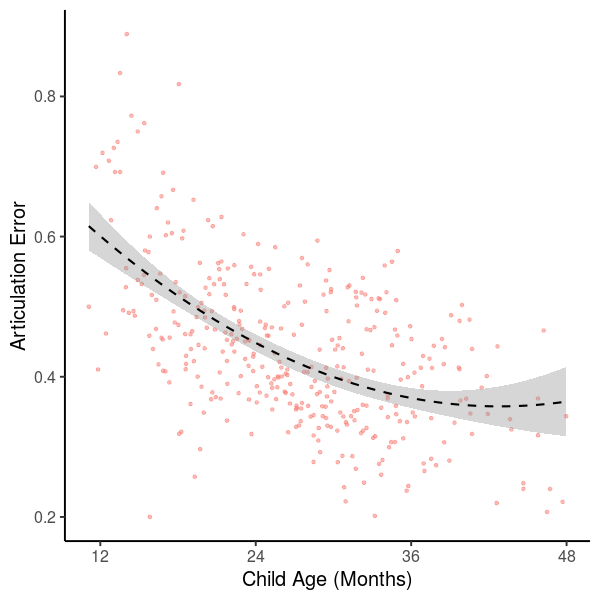

In [15]:
%%R -h 600 -w 600
chi_levdist$age_in_months = chi_levdist$target_child_age / 30.5
year_intervals_in_months = c(12,24,36,48)

p1 = ggplot(subset(chi_levdist, mean_levdist < 100 & corpus_name == 'Providence')) + geom_point(aes(x=age_in_months, y=mean_levdist, 
color=collection_name), alpha=.5)  + theme_classic(base_size = 20) +theme(legend.position="none"
) + geom_smooth(aes(x=age_in_months, y=mean_levdist), linetype='dashed', formula=y ~ poly(
    x, 2, raw=TRUE), method='lm', color='black') + ylab("Articulation Error"
) + xlab('Child Age (Months)') + scale_x_continuous(
    breaks = year_intervals_in_months, labels=year_intervals_in_months
)
ggsave('figures/edit_distances_pvd.pdf', width=6, height=6)
print(p1)